In [1]:
#Libraries used in this project

import requests
import pandas as pd
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib as mpl

import shapefile as shp
from scipy.interpolate import RBFInterpolator

In [2]:
#API key
token='---------place API key here-----------'
headers={'token':token}


In [3]:
#Data query URL - Get stations with Max. Temperature recordings in Maine
#base
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?'

#FIPS Codes ME 23 NH 33 OH 39
url=url+'locationid=FIPS:23'

#Datatype - Maximum temperature
url=url+'&datatypeid=TMAX'

#limit
url=url+'&limit=1000'

In [4]:
#Execute request, convert to JSON
r = requests.get(url, headers=headers)
d = json.loads(r.text)

In [5]:
#Initialize storage locations
stations={}
attributes=[]

#JSON parsing
#Get attributes sotred for each station
for item in d['results']:
    for key in item.keys():
        if key not in attributes: 
            attributes.append(key)

#Store d['results'] into stations, where station ID is dict. key
for item in d['results']:
    temp={}
    id=item['id']
    for attr in attributes:
        if attr in item.keys():
            temp[attr]=item[attr]
    stations[id]=temp

In [6]:
#Store stations that have data for date in stations_years; ignore others
year=2018
stations_years=[]

for key in stations.keys():
    mindate=stations[key]['mindate']
    minyear=mindate.split('-')[0]
    minyear=int(minyear)
    maxdate=stations[key]['maxdate']
    maxyear=maxdate.split('-')[0]
    maxyear=int(maxyear)
    
    #store if containing data on date of interest
    if minyear<=year and maxyear>=year:
        stations_years.append(key)

In [7]:
#Loop over valid stations and retrieve data for dates of interest; save into dictionary for dataframe conversion later
#stations_years - stations with relevant data
#request data for those stations on relevant dates

#Initialize dictionary for data storage
tmax_data={'date':[]}

for station in stations_years:
    print('Retrieving ', station)

    #build request URL for each weather station
    year = str(year)
    url='https://www.ncdc.noaa.gov/cdo-web/api/v2/data?'
    url=url+'datasetid=GHCND&'
    url=url+'datatypeid=TMAX&'
    url=url+'limit=1000&'
    url=url+'stationid='+station+'&'
    url=url+'startdate='+year+'-12-21&'
    url=url+'enddate='+year+'-12-23'
    headers={'token':token}

    r = requests.get(url, headers=headers)
    d = json.loads(r.text)
    
    #Expecting 3 dates, sometimes empty partial datasets return
    #Skip incomplete sets
    if d=={} or len(d['results'])!=3: 
        continue
    
    #Store temperature data into dictionary
    tmax_data[station]=[]
    for i, data in enumerate(d['results']):

        tmax = 1.8 * 0.1 * float(data['value']) + 32
        date=data['date'].split('T')[0]
        
        #dates apply to all stations - store dates only for the first station
        if station == stations_years[0]:
            tmax_data['date'].append(date)
        
        #Add temperature data to dictionary key - expecting 3 dates
        tmax_data[station].append(tmax)

Retrieving  GHCND:USC00170217
Retrieving  GHCND:USC00170409
Retrieving  GHCND:USC00170480
Retrieving  GHCND:USC00170583
Retrieving  GHCND:USC00170814
Retrieving  GHCND:USC00170833
Retrieving  GHCND:USC00170844
Retrieving  GHCND:USC00171131
Retrieving  GHCND:USC00171430
Retrieving  GHCND:USC00171628
Retrieving  GHCND:USC00171975
Retrieving  GHCND:USC00172048
Retrieving  GHCND:USC00172440
Retrieving  GHCND:USC00172443
Retrieving  GHCND:USC00172700
Retrieving  GHCND:USC00172765
Retrieving  GHCND:USC00172878
Retrieving  GHCND:USC00173046
Retrieving  GHCND:USC00173261
Retrieving  GHCND:USC00173295
Retrieving  GHCND:USC00173353
Retrieving  GHCND:USC00173567
Retrieving  GHCND:USC00173570
Retrieving  GHCND:USC00173588
Retrieving  GHCND:USC00173862
Retrieving  GHCND:USC00174086
Retrieving  GHCND:USC00174193
Retrieving  GHCND:USC00174324
Retrieving  GHCND:USC00174683
Retrieving  GHCND:USC00174745
Retrieving  GHCND:USC00174782
Retrieving  GHCND:USC00174927
Retrieving  GHCND:USC00175305
Retrieving

In [8]:
#Create dataframe from dictionary
df_tmax = pd.DataFrame.from_dict(tmax_data, orient='columns')
df_tmax.set_index('date', inplace=True)
df_tmax.head()

,GHCND:USC00170217,GHCND:USC00170409,GHCND:USC00170480,GHCND:USC00170583,GHCND:USC00170814,GHCND:USC00170833,GHCND:USC00170844,GHCND:USC00171131,GHCND:USC00171628,GHCND:USC00171975,...,GHCND:USW00014609,GHCND:USW00014610,GHCND:USW00014615,GHCND:USW00014764,GHCND:USW00054772,GHCND:USW00064709,GHCND:USW00094623,GHCND:USW00094626,GHCND:USW00094644,GHCND:USW00094645
date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,33.98,42.08,37.04,41.0,39.92,42.08,35.96,37.94,39.92,42.08,...,53.96,53.06,57.92,53.96,42.08,57.02,55.94,51.08,57.74,49.64
2018-12-22,46.94,57.02,53.96,50.0,51.98,50.00,51.08,53.96,55.04,53.06,...,53.06,53.06,53.06,55.04,53.96,53.96,53.06,50.00,55.94,50.90
2018-12-23,46.04,51.08,51.98,50.0,51.98,35.06,48.92,53.06,51.98,50.00,...,31.10,30.20,31.10,35.96,33.08,33.98,33.98,26.24,33.44,29.66


In [9]:
#Initialize some values - temperature, latitude, longitude measurements
lat=[]
long=[]
temperature=[]

#Get station ids with valid data
columns=df_tmax.columns

In [10]:
#Extract data if present on date of interest
#Data to be used for plotting
date='2018-12-22'
for c in columns:
    if np.isnan(df_tmax.loc[date,c]): 
        continue
    
    lat.append(stations[c]['latitude'])
    long.append(stations[c]['longitude'])
    temperature.append(df_tmax.loc[date,c])

In [11]:
#Convert data to numpy arrays
lat=np.array(lat)
long=np.array(long)
temperature=np.array(temperature)

In [12]:
#Read in data from the shapefile - Outline of map
#Shapefile contains map of US States
sf = shp.Reader('states\\cb_2018_us_state_500k.shp')
# index=-1
index=0

#Find Maine - State Postal codes used as identifiers
for record in sf.shapeRecords():
    if record.record[4]=='ME':
#         index=count
        break
    index=index+1

#Parse coordinate data
parts=sf.shapeRecords()[index].shape.parts
sx=[]
sy=[]
points=sf.shapeRecords()[index].shape.points

#Need to break portions of outlines into separate lists
#sx, sy contain lists of lat/long values defining outlines
#if sx, sy are a list of lists, there is more than 1 outline defining the state - islands or multiple parts like Michigan
#parts indicates number of outlines - state boundary, islands, etc.
if len(parts)==1:    
    for point in points:
        sx.append(point[0])
        sy.append(point[1])
#if more than 1 boundary, parts gives indices of each break
else: 
    for j in range(len(parts)-1):
        px=[]
        py=[]
        for k in range(parts[j],parts[j+1]):
            px.append(points[k][0])
            py.append(points[k][1])
        sx.append(px)
        sy.append(py)
        
    #last part
    px=[]
    py=[]
    for j in range(parts[-1], len(points)):
        px.append(points[j][0])
        py.append(points[j][1])
    sx.append(px)
    sy.append(py)

#Assemble lists of lat., long. for entire state - used for map bounds
latpts=[]
longpts=[]
for i in range(len(sx)):
    longpts.extend(sx[i])
    latpts.extend(sy[i])

#Covnert to Numpy arrays
longpts=np.array(longpts)
latpts=np.array(latpts)

In [13]:
#RBFInterpolator Approach
#Unstructured interpolation from weather stations to grid of points for plotting

#size of grid
nx, ny = 300, 300

#grid border outside of weather station bounding box, degrees lat/lon.
border=.5

#create and organize grid - create 1d arrays of x, y coordinates that are nx x ny long
xi = np.linspace(longpts.min()-border, longpts.max()+border, nx)
yi = np.linspace(latpts.max()+border, latpts.min()-border, ny)
xi, yi = np.meshgrid(xi, yi)

#arrange arrays
xiyi=np.stack([xi.ravel(),yi.ravel()], -1)

#preare lat/lon. to fit interpolator
longlat=np.stack([long.ravel(),lat.ravel()],-1)

#Fit interpolator from unstructured temperature observations
f = RBFInterpolator(longlat, temperature.ravel(), kernel='linear', smoothing=0)

#Calcualate values at structured grid points and reshape from 1d array into nx by ny array
grid=f(xiyi).reshape(xi.shape)

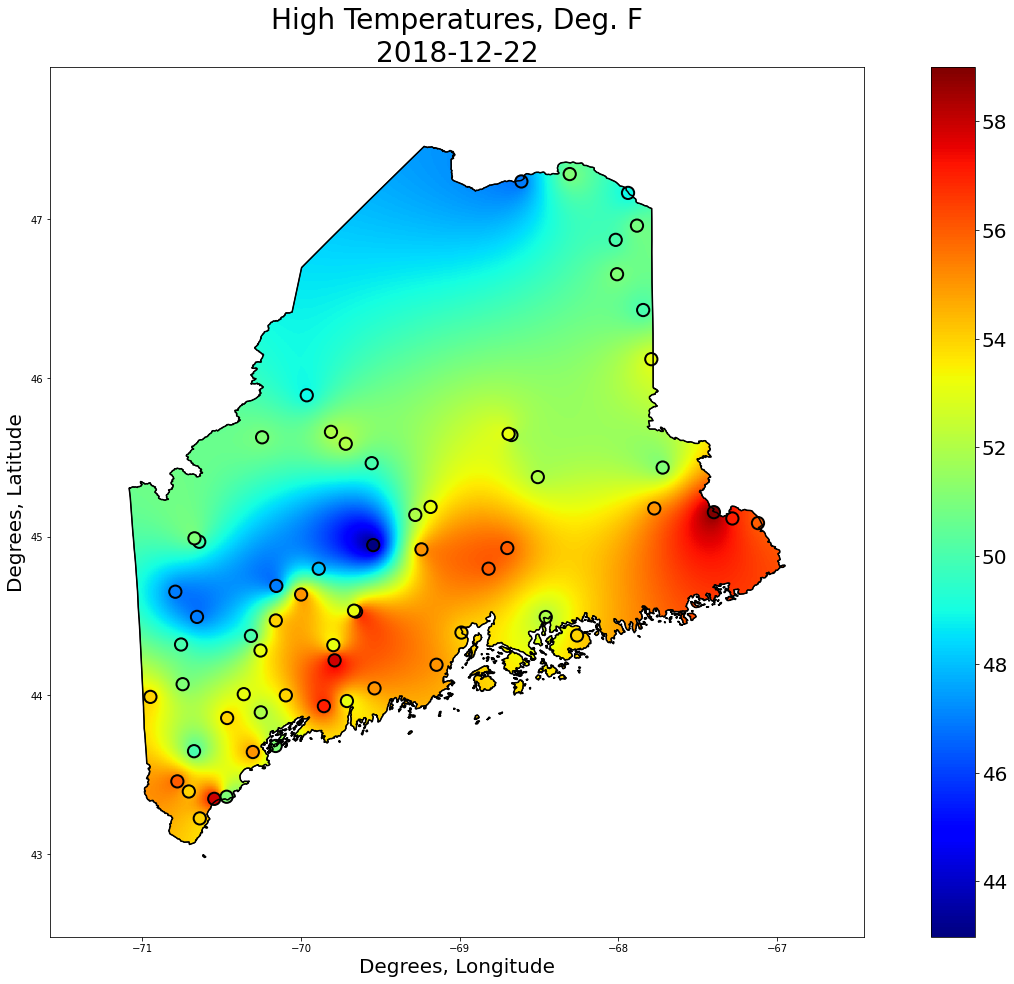

In [14]:
#Matplotlib plotting - set up axis labels and formatting
#Use for-loop to plot the interpolated grid data on loops within the state (islands, main portion)
#Overlay scatter plot of weather station locations and readings
#Set contour colorbar options

plt.figure()
plt.gcf().set_size_inches(24,16)

#title, axes, label font sizes
plt.xlabel('Degrees, Longitude', fontsize=20)
plt.ylabel('Degrees, Latitude', fontsize=20)
plt.title('High Temperatures, Deg. F\n'+str(date), fontsize=28)

#x, y axis font size
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

#plot outline parts of each state - islands, etc.
for i in range(len(sx)):
    psx=np.array(sx[i])
    psy=np.array(sy[i])
    path=[]
    
    #create path for masking state shape
    for i in range(len(psx)):
        path.append([psx[i],psy[i]])
    path=Path(path)
    patch=PathPatch(path, facecolor='none')
    plt.gca().add_patch(patch)
    
    #plot state outline
    plt.plot(psx,psy, 'k')
    
    #plot masked contour grid
    im=plt.imshow(grid, cmap='jet',
        extent=(longpts.min()-border, longpts.max()+border, 
        latpts.min()-border, latpts.max()+border),
        clip_path=patch, clip_on=True)
    
    #plt.hold(True)
    im.set_clip_path(patch)

#scatter plot
plt.scatter(long,lat,s=150, c=temperature, cmap='jet', linewidth=2, edgecolors='black')

#add colorbar and adjust label size
cmap = plt.cm.get_cmap('jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=20)